In [2]:
#Getting drug data from ChEMBL database
#This script connects to the ChEMBL database and retrieves information about drugs and their interactions with a specified protein target.

import importlib
import chembl_connect as cc
importlib.reload(cc)
import pandas as pd
import json 

df = pd.read_csv("drug.csv")
drug_names = df["Drug"].dropna().unique().tolist()
target_names = ["Dopamine transporter"]

for protein in target_names:
    interaction = cc.main(drug_list= drug_names, protein_name= protein)

# Save all records to a CSV file
df = pd.DataFrame(interaction)
output_file = "drug_target_interactions.csv"
df.to_csv(output_file, index=False)
print(f"\nAll interactions saved to {output_file}.")

Searching for ChEMBL ID for target: 'Dopamine transporter'...
{'q': 'Dopamine transporter', 'limit': 1, 'format': 'json', 'organism': 'Homo sapiens'}
b'{"page_meta": {"limit": 1, "next": "/chembl/api/data/target/search.json?limit=1&offset=1&q=Dopamine+transporter&organism=Homo+sapiens", "offset": 0, "previous": null, "total_count": 236}, "targets": [{"cross_references": [], "organism": "Homo sapiens", "pref_name": "Dopamine transporter", "score": 19.0, "species_group_flag": false, "target_chembl_id": "CHEMBL238", "target_components": [{"accession": "Q01959", "component_description": "Sodium-dependent dopamine transporter", "component_id": 346, "component_type": "PROTEIN", "relationship": "SINGLE PROTEIN", "target_component_synonyms": [{"component_synonym": "DAT", "syn_type": "UNIPROT"}, {"component_synonym": "DAT1", "syn_type": "GENE_SYMBOL_OTHER"}, {"component_synonym": "DA transporter", "syn_type": "UNIPROT"}, {"component_synonym": "SLC6A3", "syn_type": "GENE_SYMBOL"}, {"component_sy

In [16]:
##Building Similarity Matrix
#This script calculates the pairwise Tanimoto similarity between drugs based on their Morgan fingerprints.
import similarity as sim
importlib.reload(sim)


drugs_df = pd.read_csv("drug_target_interactions.csv")

#create a new dataframe to store the drug names and their corresponding SMILES strings
drug_smiles= drugs_df[['drug_name', 'canonical_smiles']].dropna().drop_duplicates()

#generate Morgan fingerprints for each drug using the canonical SMILES strings
drug_smiles['fingerprint'] = drug_smiles['canonical_smiles'].apply(sim.get_morgan_fingerprint)
print(drug_smiles.head())

# calculates the Tanimoto similarity between the fingerprints of each drug and a reference drug 
results = []

for i in range(len(drug_smiles)): #select each drug one by one 
    drug1 = drug_smiles.iloc[i] #get the current drug row
    for j in range(len(drug_smiles)): #for each drug, loop through all drugs again to compare
        if i == j:
            continue # skip if it's the same drug
        drug2 = drug_smiles.iloc[j] #get the next drug row
        fp1 = drug1["fingerprint"] 
        fp2 = drug2["fingerprint"] 
        
        sim_score = sim.calculate_tanimoto_similarity(fp1, fp2) # calculate the similarity score between the two fingerprints
        results.append({
            'drug_1': drug1['drug_name'],
            'drug_2': drug2['drug_name'],
            'similarity': sim_score
        })

similarity_df = pd.DataFrame(results)
similarity_df.to_csv("pairwise_drug_similarity.csv", index=False)

#Find the 'k' most similar drugs
similarities = pd.read_csv("pairwise_drug_similarity.csv")



                       drug_name                      canonical_smiles  \
0                Methylphenidate            COC(=O)C(c1ccccc1)C1CCCCN1   
4  Methylphenidate Hydrochloride         COC(=O)C(c1ccccc1)C1CCCCN1.Cl   
6                    Amphetamine                        CC(N)Cc1ccccc1   
7                    Atomoxetine     CNCC[C@@H](Oc1ccccc1C)c1ccccc1.Cl   
8                      Modafinil  NC(=O)C[S+]([O-])C(c1ccccc1)c1ccccc1   

                                         fingerprint  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
6  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


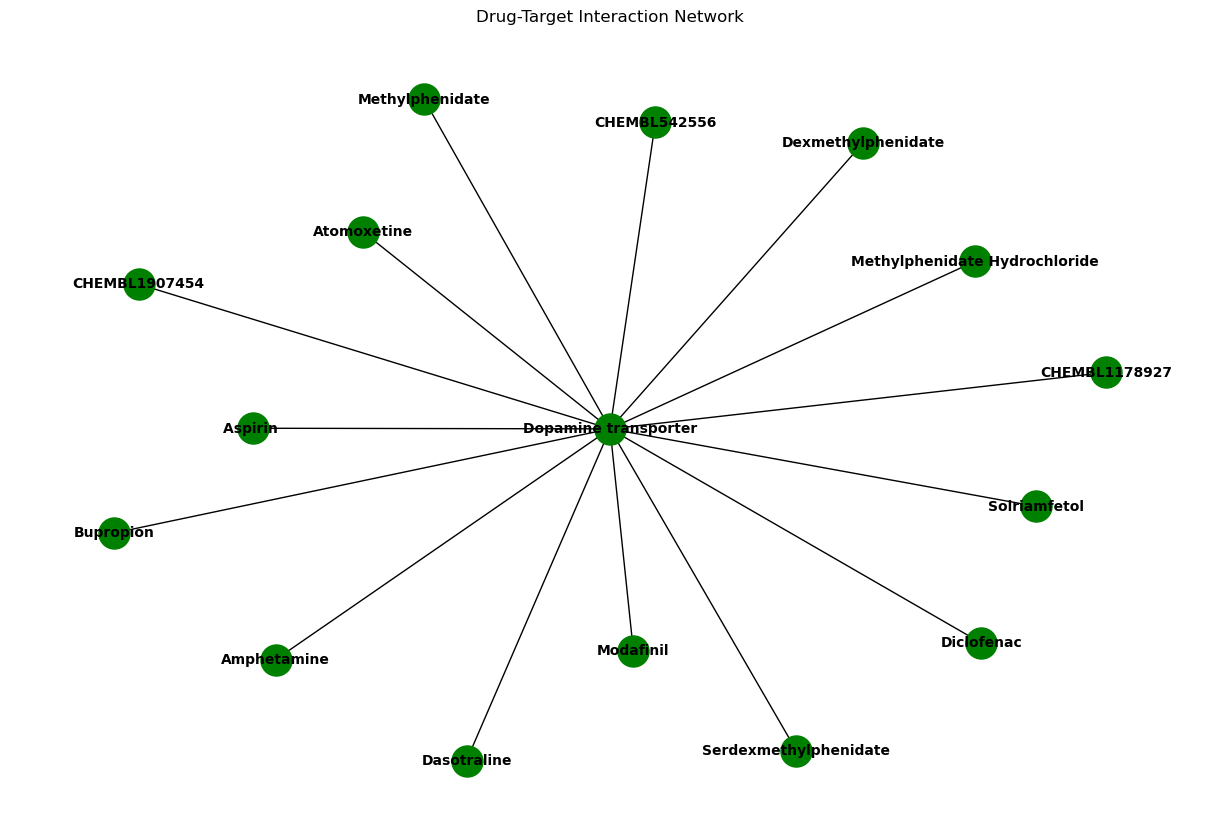

In [17]:
##Building DTI Network 
#This script builds a drug-target interaction (DTI) network from the drug-target interactions data.

import networkx as nx
import matplotlib.pyplot as plt

interactions = drugs_df[['drug_name', 'target_name']].dropna()
interaction_pairs = list(interactions.itertuples(index=False, name=None))

drugs = drug_smiles['drug_name'].unique().tolist()
targets = drugs_df['target_name'].dropna().unique().tolist()

G = sim.build_dti_network(interaction_pairs, drugs, targets)

# Draw the graph (source: https://networkx.org/documentation/stable/reference/drawing.html)
plt.figure(figsize=(12, 8))
nx.draw_spring(G, with_labels=True, node_size=500, node_color="green", font_size=10, font_weight="bold")
plt.title("Drug-Target Interaction Network")
plt.show()

Random Forest Classification
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.5
F1: 0.6666666666666666
AUROC: 0.75
APRC: 0.8333333333333333


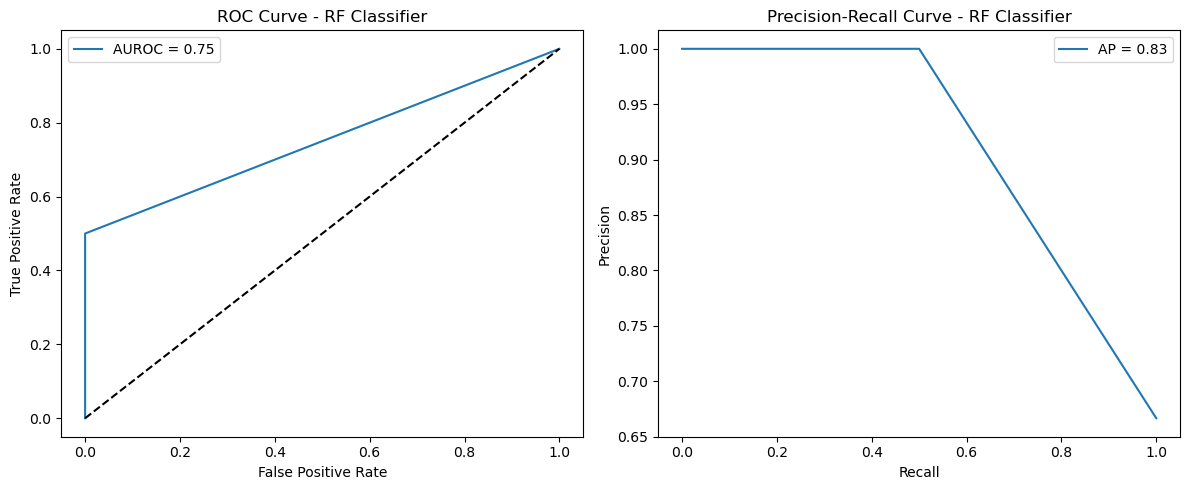

Linear Regression
MSE: 0.3339481481481488
RMSE: 0.577882469147619
MAE: 0.5777777777777784
R²: 0.7618738247660091


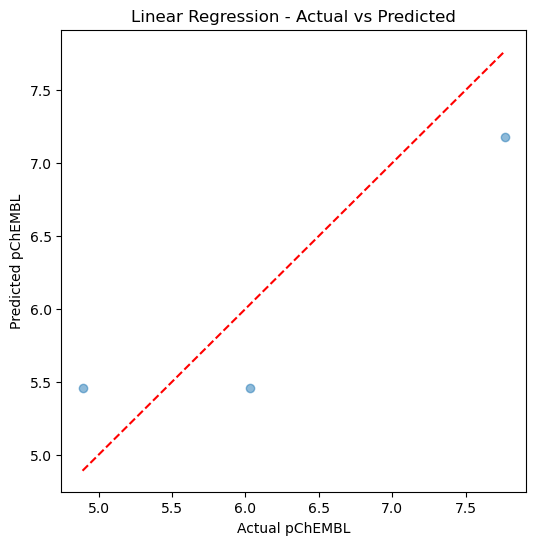

In [3]:

from similarity import get_morgan_fingerprint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve,
    precision_recall_curve, mean_squared_error,
    mean_absolute_error, r2_score
)
import matplotlib.pyplot as plt


# 1. Load and prepare the data

dt_df = pd.read_csv("drug_target_interactions.csv")
dt_df = dt_df.dropna(subset=["canonical_smiles", "pchembl_value"])

# Morgan fingerprints
dt_df["fingerprint"] = dt_df["canonical_smiles"].apply(lambda x: get_morgan_fingerprint(x, n_bits=2048))
dt_df = dt_df.dropna(subset=["fingerprint"])

# Convert fingerprints to numpy array
X = np.array([np.array(fp) for fp in dt_df["fingerprint"]])


# 2. Classification: Active vs Not Active

dt_df["active"] = (dt_df["pchembl_value"] >= 6).astype(int)
y_class = dt_df["active"]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_class, test_size=0.2, random_state=42)

rf_cls = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf_cls.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_cls = rf_cls.predict(X_test_cls)
y_prob_cls = rf_cls.predict_proba(X_test_cls)[:, 1]

# Metrics
print("Random Forest Classification")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls))
print("Recall:", recall_score(y_test_cls, y_pred_cls))
print("F1:", f1_score(y_test_cls, y_pred_cls))
print("AUROC:", roc_auc_score(y_test_cls, y_prob_cls))
print("APRC:", average_precision_score(y_test_cls, y_prob_cls))

# Plots
fpr, tpr, _ = roc_curve(y_test_cls, y_prob_cls)
precision, recall, _ = precision_recall_curve(y_test_cls, y_prob_cls)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc_score(y_test_cls, y_prob_cls):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RF Classifier")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {average_precision_score(y_test_cls, y_prob_cls):.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - RF Classifier")
plt.legend()
plt.tight_layout()
plt.show()


# 3. Regression: Linear Regression on pChEMBL values

y_reg = dt_df["pchembl_value"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

y_pred_reg = lin_reg.predict(X_test_reg)

# Regression Metrics
print("Linear Regression")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("R²:", r2_score(y_test_reg, y_pred_reg))

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], 'r--')
plt.xlabel("Actual pChEMBL")
plt.ylabel("Predicted pChEMBL")
plt.title("Linear Regression - Actual vs Predicted")
plt.show()






SVM Classification
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.5
F1: 0.6666666666666666
AUROC: 0.75
APRC: 0.8333333333333333


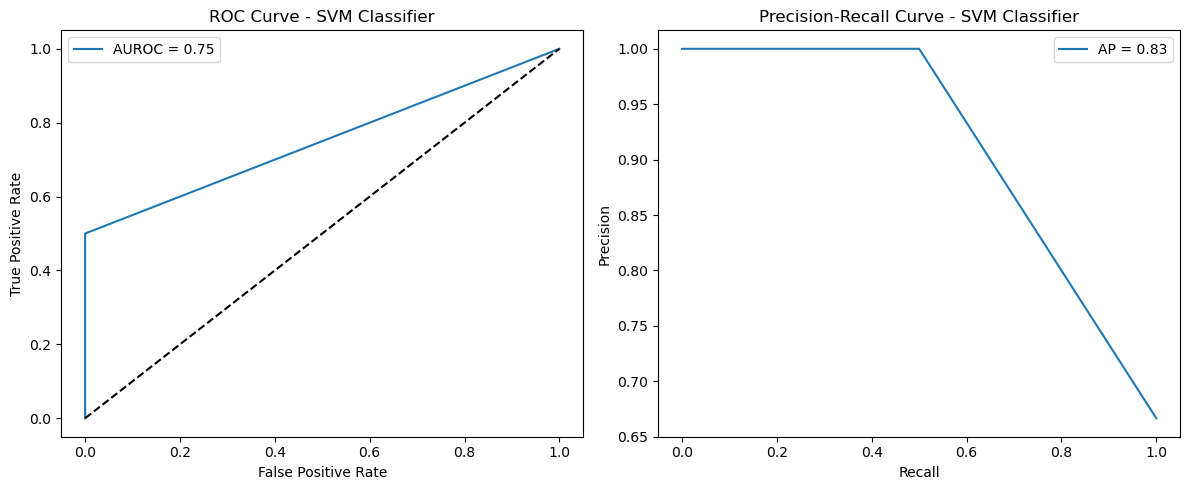

In [4]:
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



# SVM for Classification
svm_cls = make_pipeline(
    StandardScaler(),  
    SVC(
        kernel='rbf',  
        C=1.0,        
        gamma='scale', 
        probability=True,  
        class_weight='balanced',  
        random_state=42
    )
)

svm_cls.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_cls = svm_cls.predict(X_test_cls)
y_prob_cls = svm_cls.predict_proba(X_test_cls)[:, 1]

# Metrics
print("\nSVM Classification")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls))
print("Recall:", recall_score(y_test_cls, y_pred_cls))
print("F1:", f1_score(y_test_cls, y_pred_cls))
print("AUROC:", roc_auc_score(y_test_cls, y_prob_cls))
print("APRC:", average_precision_score(y_test_cls, y_prob_cls))

# Plots 
fpr, tpr, _ = roc_curve(y_test_cls, y_prob_cls)
precision, recall, _ = precision_recall_curve(y_test_cls, y_prob_cls)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc_score(y_test_cls, y_prob_cls):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM Classifier")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {average_precision_score(y_test_cls, y_prob_cls):.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - SVM Classifier")
plt.legend()
plt.tight_layout()
plt.show()

Logistic Regression Metrics:
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.5
F1: 0.6666666666666666
AUROC: 0.75
AUPRC: 0.8333333333333333


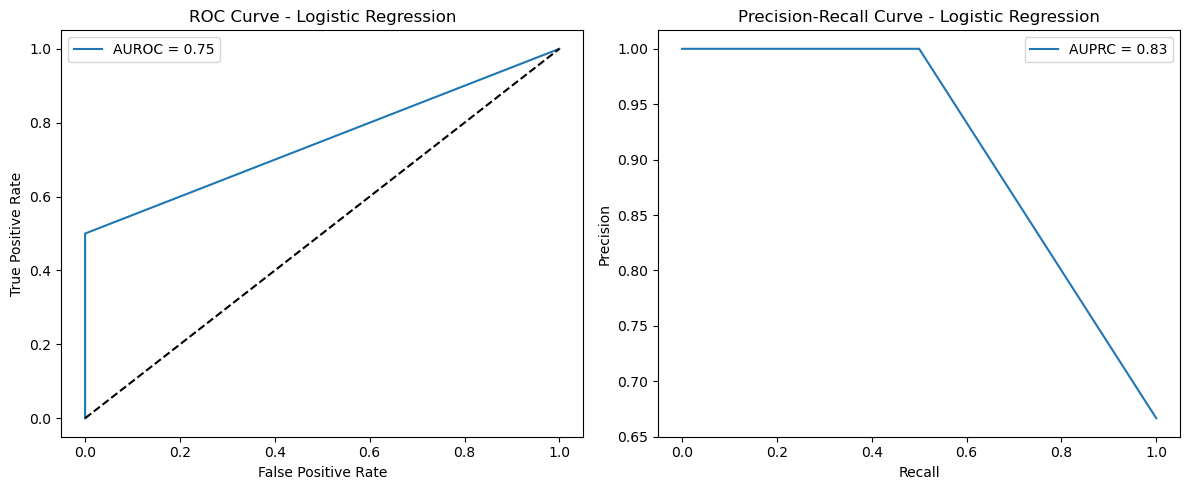

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, average_precision_score, 
                            roc_curve, precision_recall_curve)

# 1. Prepare the binary classification target 
dt_df["active"] = (dt_df["pchembl_value"] >= 6).astype(int)
y_class = dt_df["active"]

# 2. Split data 
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

# 3. Train Logistic Regression 
log_reg = LogisticRegression(
    max_iter=1000,          # Ensure convergence (default=100 may not suffice)
    class_weight="balanced", # Handle imbalanced classes
    random_state=42,        # Reproducibility
    penalty='l2',           # Regularization (default)
    solver='liblinear'      # Works well for small-to-medium datasets
)
log_reg.fit(X_train_cls, y_train_cls)

# 4. Predictions 
y_pred_cls = log_reg.predict(X_test_cls)         
y_prob_cls = log_reg.predict_proba(X_test_cls)[:, 1]  

# 5. Metrics
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls))
print("Recall:", recall_score(y_test_cls, y_pred_cls))
print("F1:", f1_score(y_test_cls, y_pred_cls))
print("AUROC:", roc_auc_score(y_test_cls, y_prob_cls))
print("AUPRC:", average_precision_score(y_test_cls, y_prob_cls))

# 6. Plot ROC and Precision-Recall Curves
fpr, tpr, _ = roc_curve(y_test_cls, y_prob_cls)
precision, recall, _ = precision_recall_curve(y_test_cls, y_prob_cls)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc_score(y_test_cls, y_prob_cls):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUPRC = {average_precision_score(y_test_cls, y_prob_cls):.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Example unknown molecule (replace with your SMILES)
unknown_smiles = "O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl"  
unknown_mol = Chem.MolFromSmiles(unknown_smiles)

# Generate Morgan fingerprint (must match training specs)
unknown_fp = AllChem.GetMorganFingerprintAsBitVect(unknown_mol, radius=2, nBits=2048)
unknown_fp_array = np.array([list(unknown_fp)])  # Reshape for model input

# Predict probability of being active (pChEMBL ≥ 6)
prob_active = rf_cls.predict_proba(unknown_fp_array)[:, 1][0]  
predicted_class = rf_cls.predict(unknown_fp_array)[0]  # 0 or 1

print(f"Probability of being active: {prob_active:.2f}")
print(f"Predicted class: {'Active' if predicted_class == 1 else 'Inactive'}")

Probability of being active: 0.41
Predicted class: Inactive


[16:05:42] DEPRECATION WARNING: please use MorganGenerator
